In [5]:
%%bash
ls /nvme0n1p2/ifashion/

item_data.txt
item_data.txt.zip
outfit_data.txt
outfit_data.txt.zip
README.md
user_data.txt
user_data.txt.7z


In [22]:
user_path = '/nvme0n1p2/ifashion/user_data.txt'
item_path = '/nvme0n1p2/ifashion/item_data.txt'
outfit_path = '/nvme0n1p2/ifashion/outfit_data.txt'

## Data Format

Outfit data
```
outfit_id,item_id;item_id;item_id...
```

User data
```
user_id,item_id;item_id;...,outfit_id
```

Item data
```
item_id,cate_id,pic_url,title
```

### User data

In [8]:
user_file = []
user_outfit_map = set()
with open(user_path, 'r') as f1:
    for idx, line in enumerate(f1):
        user_file.append(line)
        user, _, outfit = line.split(',')
        if (user,outfit) not in user_outfit_map:
            user_outfit_map.add((user,outfit))
        else:
            print('duplicated user-outfit pair')

user data 中的 `user-outfit pair` 无重复。

In [9]:
user_set = set()
for line in user_file:
    user, _, outfit = line.split(',')
    if user not in user_set:
        user_set.add(user)
    else:
        print("duplicated users")
        break

duplicated users


In [11]:
outfit_set = set()
for line in user_file:
    user, _, outfit = line.split(',')
    if user not in user_set:
        outfit_set.add(outfit)
    else:
        print("duplicated outfit")
        break

duplicated outfit


user data 即为 user-item interactions

In [31]:
user_set = set()
outfit_set = set()
for line in user_file:
    user, _, outfit = line.split(',')
    user_set.add(user)
    outfit_set.add(outfit)
print(f"{len(user_set)} users, {len(outfit_set)} outfits")

3569112 users, 127169 outfits


### item data

In [22]:
item_set = set()
with open(item_path, 'r') as f2:
    for idx, line in enumerate(f2):
        try:
            item, cate, pic, title = line.split(',')
            if item not in item_set:
                item_set.add(item)
            else:
                print('duplicated items: ', item)
                break
        except Exception as e:
            print(f'{idx} line error: {e}')

duplicated items:  34564a61f8b834ac3794c9bdef1cb6a4


为什么 item 会重复啊... 匪夷所思

In [28]:
with open(item_path, 'r') as f2:
    for idx, line in enumerate(f2):
        item = line.split(',')[0]
        if item == "34564a61f8b834ac3794c9bdef1cb6a4":
            print(line)

34564a61f8b834ac3794c9bdef1cb6a4,e89e92593584db62ee08a1502919819d,http://gw.alicdn.com/imgextra/i3/103/O1CN01ngvGkv1CdDIuyYGUQ_!!103-2-luban.png,黑色皮衣大码短款小外套皮夹克OL日系

34564a61f8b834ac3794c9bdef1cb6a4,e89e92593584db62ee08a1502919819d,http://gw.alicdn.com/imgextra/i3/103/O1CN01ngvGkv1CdDIuyYGUQ_!!103-2-luban.png,黑色皮衣大码短款小外套皮夹克OL日系



In [27]:
with open(item_path, 'r') as f2:
    for idx, line in enumerate(f2):
        try:
            data = line.split(',')
            item, cate, pic, title = data[0], data[1], data[2], data[3:]
        except Exception:
            print(line)

item data 只能确保前三项，即 item、cate、pic是正确的，title部分格式混乱

### outfit data

In [30]:
outfit_set = set()
with open(outfit_path, 'r') as f3:
    for line in f3:
        outfit, items = line.split(',')
        if outfit not in outfit_set:
            outfit_set.add(outfit)
        else:
            print("duplicated outfit: ", outfit)

outfit data 无重复

## 缩小数据集

完整的 ifashion 太大了，拟定缩小策略如下：
1. 从用户集随机采样 10w 个用户
2. 抽取出这些用户所有的交互记录
3. 根据 10-core 设定过滤数据集

In [ ]:
%%bash
wc -l /nvme0n1p2/ifashion/user_data.txt
wc -l /nvme0n1p2/ifashion/item_data.txt
wc -l /nvme0n1p2/ifashion/outfit_data.txt

19191117 /nvme0n1p2/ifashion/user_data.txt
5121303 /nvme0n1p2/ifashion/item_data.txt
1013136 /nvme0n1p2/ifashion/outfit_data.txt


### 用户采样 (5w)

In [23]:
import pandas as pd
import random

# 读取数据
df = pd.read_csv(user_path, sep=',', header=None)

# 第一列是 user_id
df.columns = ['user_id'] + [f'other_{i}' for i in range(1, df.shape[1])]  # 为其他列命名

# 随机选择 5 万个不同的 user_id
unique_user_ids = df['user_id'].unique()
sampled_user_ids = random.sample(list(unique_user_ids), 50000)

# 筛选出对应的记录
filtered_df = df[df['user_id'].isin(sampled_user_ids)]

# 将结果写入新文件
filtered_df.to_csv('filtered_user_data.txt', index=False, header=False)

In [24]:
%%bash
wc -l filtered_user_data.txt
du -sh filtered_user_data.txt

268616 filtered_user_data.txt
291M	filtered_user_data.txt


### 格式化数据

原始文件转为json，纯文本做筛选完全是折磨自己

#### 格式化用户采样数据

去重！去重！

In [25]:
import json
from collections import defaultdict

user_data = defaultdict(set)
with open('ifashion_out/filter/filtered_user_data.txt', 'r') as file:
    for line in file:
        user, items, _outfit = line.split(',')
        format_items = [item.replace('\n','') for item in items.split(';')]
        for item in format_items: user_data[user].add(item)

final_user_data = {}
for user in user_data:
    final_user_data[user] = list(user_data[user])

with open('ifashion_out/user_data.json', 'w', encoding='utf-8') as file:
    json.dump(final_user_data, file, ensure_ascii=False)

In [26]:
with open('ifashion_out/user_data.json', 'r', encoding='utf-8') as file:
    user_data = json.load(file)
print(len(user_data))

50000


In [27]:
%%bash
du -sh ifashion_out/user_data.json

95M	ifashion_out/user_data.json


啧，nice👍

#### 格式化 item data

In [ ]:
from collections import defaultdict
import json

origin_item_data_dict = defaultdict(dict)
with open(item_path, 'r') as origin_item_file:
    for line in origin_item_file:
        data = line.split(',')
        item = data[0]
        _cate = data[1]
        pic_url = data[2]
        title = data[3].replace('\n', '')
        # 如果有重复的仅保留最后一条
        origin_item_data_dict[item]['pic'] = pic_url
        origin_item_data_dict[item]['title'] = title

with open('ifashion_out/item_data.json', 'w', encoding='utf-8') as item_json:
    json.dump(origin_item_data_dict, item_json, ensure_ascii=False)

del origin_item_data_dict

In [ ]:
with open('ifashion_out/item_data.json', 'r') as file:
    item_data = json.load(file)
print(len(item_data))
del item_data

4747039


In [9]:
with open('ifashion_out/item_data.json', 'r') as file:
    item_data = json.load(file)

for item in item_data:
    pic_url = item_data[item]
    if pic_url == "" or pic_url is None:
        print('error')
        break

#### 格式化 outfit data

In [60]:
import json

outfit_data = {}
with open(outfit_path, 'r') as file:
    for line in file:
        data = line.split(',')
        outfit = data[0]
        items = [item.replace('\n', '') for item in data[1].split(';')]
        outfit_data[outfit] = items

with open('ifashion_out/outfit_data.json', 'w', encoding='utf-8') as file:
    json.dump(outfit_data, file, ensure_ascii=False)

In [61]:
with open('ifashion_out/outfit_data.json', 'r', encoding='utf-8') as file:
    outfit_data = json.load(file)
print(len(outfit_data))

1013136


user_data 中的 outfit 和 outfit_data 并无必然联系，即一个 outfit 对应的所有 item 不一定出现在 user data 中;

user 交互的 item，也未必在这个 outfit 对应的 outfit data 中。。。

### 筛选 10-core 数据

1. user's item num >= 10
2. item's image is exists

In [1]:
import json

with open('ifashion_out/user_data.json', 'r') as file:
    user_data = json.load(file)
with open('ifashion_out/item_data.json', 'r') as file:
    item_data = json.load(file)

统计 item 被交互次数

In [2]:
item_count = {}
for user in user_data:
    for item in user_data[user]:
        if item in item_count:
            item_count[item] += 1
        else:
            item_count[item] = 1

可以看见，user 交互的 item 数量确实很多，但是绝大多数 item 都是"孤本"

In [3]:
n1=0
n2=0
for item in item_count:
    if item_count[item] >= 10: n1+=1
    else: n2+=1
print(n1, n2)

51946 769148


In [4]:
import json

user_num=0
it_num=0
item_set = set()

with open('ifashion_out/filter_user_data.json', 'w', encoding='utf-8') as file:
    filter_user_data = {}
    for user in user_data:
        items = user_data[user]
        filter_items = [item for item in items if item_count[item] >= 10]
        if len(filter_items) >= 10:
            user_num+=1
            it_num+=len(filter_items)
            item_set.update(filter_items)
            filter_user_data[user] = filter_items
    
    json.dump(filter_user_data, file, ensure_ascii=False)
    print(f"filter user data: {len(filter_user_data)}")

print(f"{user_num} users, {len(item_set)} items, {it_num} interactions, sparsity: {(1-it_num/(user_num*len(item_set)))*100:.2f}%")


filter user data: 38404
38404 users, 51946 items, 1093973 interactions, sparsity: 99.95%


In [5]:
with open('ifashion_out/filter_user_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    print(len(data))

38404


In [6]:
%%bash
du -sh ifashion_out/filter_user_data.json

39M	ifashion_out/filter_user_data.json


nice 👍

### 生成最终数据集

In [7]:
with open('ifashion_out/interactions.txt', 'w', encoding='utf-8') as it_file:
    with open('ifashion_out/filter_user_data.json', 'r', encoding='utf-8') as user_file:
        user_data = json.load(user_file)
        for user in user_data:
            for item in user_data[user]:
                # ifashion 无 ratings，置为 1
                it_file.write(f"{user} {item} 1\n")

In [8]:
%%bash
wc -l ifashion_out/interactions.txt
du -sh ifashion_out/interactions.txt

1093973 ifashion_out/interactions.txt
71M	ifashion_out/interactions.txt


### 爬取图片

[spider_pro.py](./ifashion_out/spider_pro.py)

合并多次下载的图片

In [13]:
from pathlib import Path

# 从交互数据中抽取需要爬取图片的 items
items = set()
with open('ifashion_out/filter_user_data.json', 'r', encoding='utf-8') as user_data_file:
    user_data = json.load(user_data_file)
    for user in user_data:
        items.update(user_data[user])
print(f"total {len(items)} items")

dir1 = Path("/nvme0n1p2/ifashion/downloaded_images")
dir2 = Path("/nvme0n1p2/ifashion/images")
merge_dir = Path("/nvme0n1p2/ifashion/item_images")
merge_dir.mkdir(parents=True, exist_ok=True)

total 51946 items


构造文件列表，用 rsync 去移动

In [14]:
with open('dir2.txt', 'w') as dir2_file:
    for png_file in dir2.glob('*.png'):
        if png_file.stem in items:
            dir2_file.write(f"{png_file.resolve()}\n")

In [16]:
import re

for png_file in dir1.glob('*.png'):
    clean_name = re.sub(r'^\d+-', '', png_file.name)
    png_file.rename(png_file.parent/clean_name)

In [17]:
with open('dir1.txt', 'w') as dir1_file:
    for png_file in dir1.glob('*.png'):
        if png_file.stem in items:
            dir1_file.write(f"{png_file.resolve()}\n")

### 过滤最终数据集

最后还需要过滤一下，因为有一些 item 对应的图片不存在或者损坏了

In [19]:
from pathlib import Path

imgage_path = Path("/nvme0n1p2/ifashion/item_images/")

In [20]:
image_name_set = set()  # 所有图片的文件名(无后缀=item)
for png in imgage_path.glob('*.png'):
    image_name_set.add(png.stem)

In [21]:
with open('ifashion_out/filter_interactions.txt', 'w', encoding='utf-8') as file1:
    with open('ifashion_out/interactions.txt', 'r') as file2:
        for line in file2:
            user, item, ratings = line.split(' ')
            if item not in image_name_set: continue
            file1.write(line)

In [8]:
from collections import defaultdict
ui_dict = defaultdict(dict)
with open('ifashion_out/filter_interactions.txt', 'r', encoding='utf-8') as file:
    for line in file:
        user, item, ratings = line.split(' ')
        ui_dict[user][item] = ratings.replace('\n', '')

# 删除交互次数不足10次的用户
not_core_users = 0
with open('ifashion_out/filter_interactions.txt', 'w', encoding='utf-8') as file:
    for user, items in ui_dict.items():
        if len(items) < 10:
            not_core_users += 1
            continue
        for item, ratings in items.items():
            file.write(f"{user} {item} {ratings}\n")
            
print('delete', not_core_users, 'users')

delete 1 users


删了一个用户，user_pref 会多出来一个，不过不影响就是了，懒得处理了。

In [9]:
uset = set()
iset = set()
it_num = 0
with open('ifashion_out/filter_interactions.txt', 'r') as f:
    for line in f:
        it_num += 1
        u = line.split(' ')[0]
        i = line.split(' ')[1]
        uset.add(u)
        iset.add(i)

print(f"{len(uset)} users, {len(iset)} items, {it_num} interactions")

38403 users, 51939 items, 1093854 interactions


In [1]:
%%bash
wc -l ifashion_out/interactions.txt
wc -l ifashion_out/filter_interactions.txt

1093973 ifashion_out/interactions.txt


1093854 ifashion_out/filter_interactions.txt


## 划分数据集

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

data = pd.read_csv('ifashion_out/filter_interactions.txt', delimiter=' ', header=None)

# 检查重复行
print(f"原始数据重复行数: {data.duplicated().sum()}")

# 划分临时集和测试集，比例为8:2
temp_data, test_data = train_test_split(data, test_size=0.2, random_state=114514)
# 将临时集划分为训练集和验证集，比例为7:1
train_data, val_data = train_test_split(temp_data, test_size=0.125, random_state=114514)

os.makedirs('ifashion_ds', exist_ok=True)
temp_data.to_csv('ifashion_ds/merge_train_data.txt', index=False, header=False, sep=' ')
train_data.to_csv('ifashion_ds/train_data.txt', index=False, header=False, sep=' ')
val_data.to_csv('ifashion_ds/val_data.txt', index=False, header=False, sep=' ')
test_data.to_csv('ifashion_ds/test_data.txt', index=False, header=False, sep=' ')

# 查看划分后的数据集大小
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"测试集大小: {len(test_data)}")

# 检查是否有重复项
print(f"训练集重复行数: {train_data.duplicated().sum()}")
print(f"验证集重复行数: {val_data.duplicated().sum()}")
print(f"测试集重复行数: {test_data.duplicated().sum()}")

# 检查交叉重复项
duplicates_in_all = train_data.merge(val_data, how='inner').merge(test_data, how='inner')
print(f"训练集、验证集和测试集之间重复行数: {duplicates_in_all.shape[0]}")

原始数据重复行数: 0
训练集大小: 765703
验证集大小: 109387
测试集大小: 218773
训练集重复行数: 0
验证集重复行数: 0
测试集重复行数: 0
训练集、验证集和测试集之间重复行数: 0


按条数划分有问题，应该按每个用户的交互来分

In [1]:
import json
from collections import defaultdict

ui_dict = defaultdict(dict)
with open('ifashion_out/filter_interactions.txt', 'r') as file:
    for line in file:
        user, item, ratings = line.split(' ')
        ui_dict[user][item] = ratings.replace('\n', '')

# 持久化
with open('ifashion_ds/ui_dict.json', 'w', encoding='utf-8') as file:
    json.dump(ui_dict, file, ensure_ascii=False)

In [2]:
import random
import json
random.seed(114514)

with open('ifashion_ds/ui_dict.json', 'r', encoding='utf-8') as file:
    ui_dict = json.load(file)

ui_tuple_dict = {}
for user, it_dict in ui_dict.items():
    # 转换成元组列表, 便于分割采样
    ui_tuple_dict[user] = [(item, ratings) for item, ratings in it_dict.items()]
print(len(ui_tuple_dict))

38403


In [3]:
train_set = []
val_set = []
test_set = []
not_core = 0
for user, it_list in ui_tuple_dict.items():
    random.shuffle(it_list)  # 打乱交互数据
    it_num = len(it_list)
    if it_num < 10: not_core+=1  # 不足10个会导致对应测试集为空
    train_num = int(it_num * 0.7)
    val_num = int(it_num * 0.1) + train_num

    # 将每个用户的交互记录划分到三个子集
    for item, rating in it_list[:train_num]: train_set.append((user, item, rating))
    for item, rating in it_list[train_num:val_num]: val_set.append((user, item, rating))
    for item, rating in it_list[val_num:]: test_set.append((user, item, rating))
print(not_core)

0


In [5]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

748754
93532
251568


In [10]:
from tqdm import tqdm
def save_dataset(dataset: list[tuple[str, str, str]], filename: str):
    with open(filename, "w", encoding='utf-8') as f:
        for user, item, ratings in tqdm(dataset):
            f.write(f"{user} {item} {ratings}\n")

In [7]:
save_dataset(train_set, 'ifashion_ds/train.txt')
save_dataset(val_set, 'ifashion_ds/val.txt')
save_dataset(test_set, 'ifashion_ds/test.txt')

100%|██████████| 251568/251568 [00:00<00:00, 2139054.23it/s]


In [13]:
merge_train = []
for i in train_set: merge_train.append(i)
for j in val_set: merge_train.append(j)
print(len(merge_train))
save_dataset(merge_train, 'ifashion_ds/merge_train.txt')

842286


100%|██████████| 842286/842286 [00:00<00:00, 2369412.52it/s]


## 图像预处理

In [2]:
from transformers import CLIPProcessor, CLIPModel
from safetensors.torch import save_file
from PIL import Image
from safetensors import safe_open
import os
from tqdm import tqdm
import torch

In [3]:
model_path = "/home/yzh/code/SELFRec/model/clip-vit-base-patch32"
# 图片存储路径
directory = '/nvme0n1p2/ifashion/item_images'

图片都能正常加载，无损毁图片

In [9]:
from pathlib import Path
from PIL import Image

directory_path = Path(directory)
error_image = []

# 遍历目录下的所有图片文件
for image_path in directory_path.rglob('*.png'):
    try:
        image = Image.open(image_path)
        width, height = image.size
        if width == 1 and height == 1:
            print('1x1 image found!')
    except Exception as e:
        error_image.append(image_path.stem)

print(f"{len(error_image)} images error")

0 images error


有个问题，提取图像特征会爆 `OSError: image file is truncated`，`LOAD_TRUNCATED_IMAGES` 的试错成本就有点高了，只能暂时放弃批处理，逐图处理

In [10]:
# 加载模型
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained(model_path).to(device) # type: ignore
processor = CLIPProcessor.from_pretrained(model_path)

# 初始化计数器
image_num = 0
processed_num = 0
error_num = 0
image_embs = {}

path_list = list(directory_path.rglob('*.png'))

for image_path in tqdm(path_list, desc='process images', total=len(path_list)):
    try:
        image = Image.open(image_path)
        input = processor(images=image, return_tensors='pt').to(device) # type: ignore

        with torch.no_grad():
            # 使用get_image_features获取图像特征
            output = model.get_image_features(pixel_values=input['pixel_values'])
    
        image_embs[image_path.stem] = output
        processed_num += 1
    except Exception as e:
        error_num += 1
        with open('image_error.log', 'a') as error_log:
            error_log.write(f"{image_path}")

# 输出统计信息
print(f'Total images: {image_num}, Processed images: {processed_num}, Errors: {error_num}')
# 保存为文件
save_file(image_embs, 'images.safetensors')

/home/yzh/env/miniforge3/envs/selfrec/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
process images: 100%|██████████| 51939/51939 [41:25<00:00, 20.89it/s]  


Total images: 0, Processed images: 51938, Errors: 1


找到错误图片了，应该是缺失了尾部标记导致的，先尝试重新下载看看

In [22]:
import json
import requests

with open("ifashion_out/item_data.json", 'r') as item_file:
    item_data = json.load(item_file)

url = item_data["e6719641ea0545261a996476638bd82b"]['pic']

with open("e6719641ea0545261a996476638bd82b.png", 'wb') as wf:
    response = requests.get(url)
    wf.write(response.content)

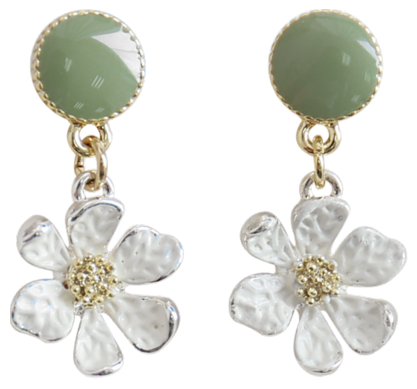

In [26]:
import matplotlib.pyplot as plt
error_image = Image.open("e6719641ea0545261a996476638bd82b.png")
plt.imshow(error_image)
plt.axis('off')  # 关闭坐标轴
plt.show()

搞定 👍

重新添加到 safetensors，顺便加点 metadata 以防万一

In [27]:
# before
from safetensors.torch import load_file, save_file
image_tensors = load_file('images.safetensors')
print(len(image_tensors))

51938


In [30]:
error_image = Image.open("/nvme0n1p2/ifashion/item_images/e6719641ea0545261a996476638bd82b.png")
input = processor(images=error_image, return_tensors='pt').to(device) # type: ignore
with torch.no_grad():
    output = model.get_image_features(pixel_values=input['pixel_values'])
image_tensors["e6719641ea0545261a996476638bd82b"] = output
metadata = {
    "type": "pt",
    "images num": "51939",
    "origin": "Alibaba iFashion of POG",
    "build by": "https://github.com/sun2ot",
    "time": "2024-10-22 14:36"
}
save_file(image_tensors, "ifashion_image.safetensors", metadata)

## 文本预处理

In [1]:
from sentence_transformers import SentenceTransformer

query_prompt_name = "s2s_query"
model = SentenceTransformer('/home/yzh/code/SELFRec/model/stella_en_1.5B_v5', device="cuda:0", trust_remote_code=True)

/home/yzh/env/miniforge3/envs/selfrec/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


生成 item text

老问题，ifashion 数据集太大了，这里只能对最终数据集进行预处理，全量数据没那个卡🤷‍♀️

In [2]:
import json
from tqdm import tqdm
import torch
from safetensors.torch import save_file

In [6]:
with open('ifashion_out/item_data.json', 'r') as item_file:
    item_data = json.load(item_file)

ds_items_data = {}  # 顺序有所谓
with open('ifashion_out/filter_interactions.txt', 'r') as ds_file:
    for line in ds_file:
        i = line.split(' ')[1]
        ds_items_data[i] = item_data[i]  # 重复项直接原值覆盖, 自带去重 no problem

In [7]:
text_list = [ds_items_data[item]['title'] for item in ds_items_data]
tensor_list = []
text_embs = {}

text_cache = []
for text in tqdm(text_list, desc='encode text'):
    text_cache.append(text)
    if len(text_cache) == 32:  # 默认batch就是32
        batch_embs = model.encode(text_cache, device='cuda:1', prompt_name=query_prompt_name, convert_to_tensor=True)
        tensor_list.append(batch_embs)
        text_cache.clear()  # 清空缓存

# 处理剩余的文本
if text_cache:
    batch_embs = model.encode(text_cache, device='cuda:1', prompt_name=query_prompt_name, convert_to_tensor=True)
    tensor_list.append(batch_embs)

all_embs = torch.cat(tensor_list, dim=0)    
print(f"output embedding shape: {all_embs.shape}")

for idx, item in enumerate(ds_items_data.keys()):
    text_embs[item] = all_embs[idx]
save_file(text_embs, 'ifashion_text.safetensors')

encode text: 100%|██████████| 51939/51939 [10:35<00:00, 81.75it/s]


output embedding shape: torch.Size([51939, 1024])


In [8]:
%%bash
rsync -avcP --remove-source-files ifashion_text.safetensors ifashion_ds

sending incremental file list


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ifashion_text.safetensors
    218,037,616 100%  367.97MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 218,090,973 bytes  received 43 bytes  145,394,010.67 bytes/sec
total size is 218,037,616  speedup is 1.00


提取出单独的 item->text 映射，为LLM增强做准备

In [1]:
item_set = set()
with open("ifashion_ds/filter_interactions.txt", 'r') as ds_file:
    for line in ds_file:
        item_set.add(line.split(' ')[1])

In [2]:
import json

with open('ifashion_out/item_data.json', 'r') as item_file:
    item_data = json.load(item_file)

In [3]:
with open('ifashion_out/ifashion_text.json', 'w', encoding='utf-8') as text_file:
    item_text = {}
    for item in item_set:
        item_text[item] = item_data[item]['title']
    
    json.dump(item_text, text_file, ensure_ascii=False)

In [4]:
with open('ifashion_out/ifashion_text.json', 'r', encoding='utf-8') as text_file:
    d = json.load(text_file)
    print(len(d))

51939


[ollama_aug.py](./ollama_aug.py) 生成用户偏好，然后调整为 json 格式

In [6]:
import json

user_pref_dict = {}
with open("ifashion_out/ifashion_user_preference-line.json", 'r') as file:
    for line in file:
        data: dict = json.loads(line)
        for user, pref in data.items():
            user_pref_dict[user] = pref

with open('ifashion_out/ifashion_user_pref.json', 'w', encoding='utf-8') as file:
    json.dump(user_pref_dict, file, ensure_ascii=False)


with open('ifashion_out/ifashion_user_pref.json', 'r') as file:
    data = json.load(file)
    print(len(data))

38404


然后补充生成失败的部分

In [7]:
import json

with open('ifashion_out/pref/ifashion_user_pref.json', 'r') as origin:
    origin_data: dict[str, str] = json.load(origin)
    print(f"before: {len(origin_data)}")

    fix_path = 'ifashion_out/pref/ifashion_user_preference-20241023_2013.json'
    fix_data: dict[str, str] = {}
    with open(fix_path, 'r') as f:
        for line in f:
            data: dict[str, str] = json.loads(line)
            for k,v in data.items():
                fix_data[k] = v
    print(f"fix: {len(fix_data)}")

    # 更新数据
    with open('ifashion_out/pref/ifashion_user_pref.fix.json', 'w', encoding='utf-8') as output:
        for k in fix_data.keys():
            if k in origin_data:
                origin_data[k] = fix_data[k]
            else:
                print(f"{k} is in fix data but not in origin data!")
        json.dump(origin_data, output, ensure_ascii=False)
    print(f"after: {len(origin_data)}")

before: 38404
fix: 6
after: 38404


最后生成 user pref embeddings

In [ ]:
# 读取数据
with open('ifashion_out/pref/ifashion_user_pref.json', 'r', encoding='utf-8') as file:
    user_pref: dict[str, str] = json.load(file)

user_pref_embs: dict[str, torch.Tensor] = {}
all_embs = []

user_pref_cache = []
for user in tqdm(user_pref, desc='user pref'):
    user_pref_cache.append(user_pref[user])
    if len(user_pref_cache) == 16:
        pre_embs = model.encode(user_pref_cache, prompt_name=query_prompt_name, device='cuda:0', batch_size=16, convert_to_tensor=True)
        all_embs.append(pre_embs)
        user_pref_cache.clear()

if len(user_pref_cache) > 0:
    pre_embs = model.encode(user_pref_cache, prompt_name=query_prompt_name, device='cuda:0', batch_size=16, convert_to_tensor=True)
    all_embs.append(pre_embs)

final_embs = torch.cat(all_embs, dim=0) 
print(f"output embedding shape: {final_embs.shape}")

for idx, user in enumerate(user_pref):
    user_pref_embs[user] = final_embs[idx]

metadata = {
    "type": "pt",
    "user num": "38404",
    "dim": "1024",
    "build by": "https://github.com/sun2ot",
    "time": "2024-10-23 20:22"
}

save_file(user_pref_embs, "user_pre_embs.safetensors", metadata)

# 继续缩小数据集

当前数据规模，在 A800 上随便一个多模态的模型都复现不出来，经过我的观察，发现他们的数据集有如下规律：
1. ui 数量多的，要么交互次数特别少，要么多模态特征维度很小
2. ui 数量少的，交互次数和多模态特征才有可能大

说白了，A800 都跑不起来，他们凭啥能跑，凭一个函数600行吗😅

In [15]:
import json
import random
random.seed(114514)

with open('ifashion_ds/ui_dict.json', 'r') as file:
    ui_dict: dict[str, dict[str, int]] = json.load(file)

# 随机采样 2w 个 item
item_set = set()
for user, item_scores in ui_dict.items():
    item_set.update(item_scores.keys())
sample_items = random.sample(list(item_set), 20000)

for user, item_scores in ui_dict.items():
    # 筛选 sample item
    filter_item_scores = {item: score for item, score in item_scores.items() if item in sample_items}
    # 最大交互次数为 20
    if len(filter_item_scores) > 20:
        select_items = random.sample(list(filter_item_scores.keys()), 20)
        ui_dict[user] = {item: filter_item_scores[item] for item in select_items}
    else:
        ui_dict[user] = filter_item_scores

with open('ifashion_tiny/ui_dict.json', 'w') as file:
    json.dump(ui_dict, file, ensure_ascii=False)

In [16]:
with open('ifashion_tiny/ui_dict.json', 'r') as file:
    filter_ui_dict = json.load(file)

print(f"user num: {len(filter_ui_dict)}")

it_num = 0
item_set = set()
for user, item_scores in filter_ui_dict.items():
    it_num += len(item_scores)
    item_set.update(item_scores.keys())

print(f"item num: {len(item_set)}")
print(f"interactions: {it_num}")

user num: 38403
item num: 20000
interactions: 382765


~~先试一下这个数量级能不能跑吧~~

把 item 缩到 2w 了，再跑不动那就真有意思了

In [17]:
import random
import json
random.seed(114514)

with open('ifashion_tiny/ui_dict.json', 'r', encoding='utf-8') as file:
    ui_dict = json.load(file)

ui_tuple_dict = {}
for user, item_scores in ui_dict.items():
    # 转换成元组列表, 便于分割采样
    ui_tuple_dict[user] = [(item, ratings) for item, ratings in item_scores.items()]
print(len(ui_tuple_dict))

38403


In [18]:
train_set = []
val_set = []
test_set = []
not_core = 0
for user, it_list in ui_tuple_dict.items():
    random.shuffle(it_list)  # 打乱交互数据
    it_num = len(it_list)
    if it_num < 10: not_core+=1  # 不足10个会导致对应测试集为空
    train_num = int(it_num * 0.7)
    val_num = int(it_num * 0.1) + train_num

    # 将每个用户的交互记录划分到三个子集
    for item, rating in it_list[:train_num]: train_set.append((user, item, rating))
    for item, rating in it_list[train_num:val_num]: val_set.append((user, item, rating))
    for item, rating in it_list[val_num:]: test_set.append((user, item, rating))
print(not_core)

21238


In [19]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

251914
21348
109503


In [20]:
from tqdm import tqdm
def save_dataset(dataset: list[tuple[str, str, str]], filename: str):
    with open(filename, "w", encoding='utf-8') as f:
        for user, item, ratings in tqdm(dataset):
            f.write(f"{user} {item} {ratings}\n")

In [21]:
save_dataset(train_set, 'ifashion_tiny/train.txt')
save_dataset(val_set, 'ifashion_tiny/val.txt')
save_dataset(test_set, 'ifashion_tiny/test.txt')

100%|██████████| 109503/109503 [00:00<00:00, 1872852.04it/s]


In [22]:
merge_train = []
for i in train_set: merge_train.append(i)
for j in val_set: merge_train.append(j)
print(len(merge_train))
save_dataset(merge_train, 'ifashion_tiny/merge_train.txt')

273262


100%|██████████| 273262/273262 [00:00<00:00, 2078750.26it/s]
